<a href="https://colab.research.google.com/github/loureiro85/python_env_setup/blob/master/cdi_index_extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q yahooquery

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
from yahooquery import Ticker

In [4]:
CDI_TABLE_URL = 'https://blog.nubank.com.br/cdi-2021/'

MONTHS = {
    'Janeiro': 1,
    'Fevereiro': 2,
    'Março': 3,
    'Abril': 4,
    'Maio': 5,
    'Junho': 6,
    'Julho': 7,
    'Agosto': 8,
    'Setembro': 9,
    'Outubro': 10,
    'Novembro': 11,
    'Dezembro': 12,
}

In [5]:
df = pd.read_html(
    io=CDI_TABLE_URL, 
    header=0, 
    index_col=0,
    decimal=','
    )[2]
df.drop('Acumulado do ano', inplace=True)
df = df.replace({
    '%': '', 
    ',': '.',
    '–': np.nan
    }, 
    regex=True)
df = df.astype(float)
df

,2021,2020,2019,2018,2017,2016,2015
Mês/Ano,,,,,,,
Janeiro,0.15,0.38,0.54,0.58,1.08,1.05,0.93
Fevereiro,0.13,0.29,0.49,0.46,0.86,1.00,0.82
Março,0.20,0.34,0.47,0.53,1.05,1.16,1.04
Abril,0.21,0.28,0.52,0.52,0.79,1.05,0.95
Maio,0.27,0.24,0.54,0.52,0.93,1.11,0.98
Junho,0.31,0.21,0.47,0.52,0.81,1.16,1.07
Julho,NaN,0.19,0.57,0.54,0.80,1.11,1.18
Agosto,NaN,0.16,0.50,0.57,0.80,1.21,1.11
Setembro,NaN,0.16,0.46,0.47,0.64,1.11,1.11


In [6]:
# Stack data
df_cdi = (df
    .stack()
    .reset_index()
    .rename(columns={
        'Mês/Ano': 'month', 
        'level_1': 'year', 
        0: 'cdi_month'
    }))

df_cdi = df_cdi.replace({'month': MONTHS})
df_cdi = df_cdi.reindex(columns=['year', 'month', 'cdi_month'])
df_cdi = df_cdi.sort_values(['year', 'month'], ascending=True)

# Convert to date
df_cdi['date'] = pd.to_datetime(
    df_cdi['year'].astype(str) 
    + '-' 
    + df_cdi['month'].astype(str)
    )
df_cdi = df_cdi.drop(columns=['year', 'month'])
# df_cdi = df_cdi.reset_index().drop(columns='index')
df_cdi = df_cdi.set_index('date')
df_cdi['cdi_cum'] = df_cdi['cdi_month'].cumsum()
df_cdi

,cdi_month,cdi_cum
date,,
2015-01-01,0.93,0.93
2015-02-01,0.82,1.75
2015-03-01,1.04,2.79
2015-04-01,0.95,3.74
2015-05-01,0.98,4.72
...,...,...
2021-02-01,0.13,50.22
2021-03-01,0.20,50.42
2021-04-01,0.21,50.63


In [74]:
df_cdi_month = df_cdi.resample('M').mean()
df_cdi_month

,cdi_month,cdi_cum
date,,
2015-01-31,0.93,0.93
2015-02-28,0.82,1.75
2015-03-31,1.04,2.79
2015-04-30,0.95,3.74
2015-05-31,0.98,4.72
...,...,...
2021-02-28,0.13,50.22
2021-03-31,0.20,50.42
2021-04-30,0.21,50.63


# Get stock values

In [75]:
STOCKS = [
    'BOVA11.SA',
    'ITUB4.SA',
    'PETR4.SA',
    'BBDC4.SA',
    # 'PETR3.SA',
    # 'VALE3.SA',
    # 'B3SA3.SA',
    # 'ABEV3.SA',
    # 'MGLU3.SA',
    # 'ITSA4.SA',
    # 'WEGE3.SA',
    ]
 
stock = Ticker(STOCKS)
df_stock_raw = stock.history(period='5y', interval='1d')
df_stock_raw = df_stock_raw.reset_index()
df_stock_raw['date'] = pd.to_datetime(df_stock_raw['date'])
df_stock = df_stock_raw.pivot(index='date', values='close', columns='symbol').dropna(how='all')
df_stock

symbol,BBDC4.SA,BOVA11.SA,ITUB4.SA,PETR4.SA
date,,,,
2016-07-18,18.087902,54.880001,20.624243,11.55
2016-07-19,18.019033,55.049999,20.503031,11.78
2016-07-20,18.175556,54.970001,20.824242,11.82
2016-07-21,18.037815,54.930000,20.545454,11.85
2016-07-22,18.156775,55.049999,20.672728,11.94
...,...,...,...,...
2021-07-12,25.209999,NaN,29.690001,27.73
2021-07-13,25.190001,123.320000,29.870001,27.90
2021-07-14,25.299999,123.470001,29.910000,27.67


In [81]:
df_stock_month = df_stock.resample('M').mean()
df_stock_month

symbol,BBDC4.SA,BOVA11.SA,ITUB4.SA,PETR4.SA
date,,,,
2016-07-31,17.952667,55.081000,20.486060,11.767000
2016-08-31,18.083820,56.199565,21.558893,12.267826
2016-09-30,18.253968,56.603333,21.743145,13.529524
2016-10-31,19.733909,60.490000,23.705909,16.593500
2016-11-30,18.943150,59.704000,23.902333,15.565000
...,...,...,...,...
2021-03-31,23.060474,109.537431,27.331304,22.916957
2021-04-30,23.450045,114.695573,27.361000,23.755500
2021-05-31,25.153809,117.557143,28.561428,25.384762


In [96]:
DATE_BUY = '2019-01'
DATE_SELL = '2021-06'

df_stock_month = df_stock.resample('M').mean()

df_stock_delta = df_stock_month.loc[DATE_SELL].iloc[0] - df_stock_month.loc[DATE_BUY].iloc[0]
df_stock_delta

df_cdi_delta = df_cdi_month['cdi_cum'].loc[DATE_SELL].iloc[0] - df_cdi_month['cdi_cum'].loc[DATE_BUY].iloc[0]
df_cdi_delta

# Join data
df_stock_delta['cdi_cum'] = df_cdi_delta
df_stock_delta

symbol
BBDC4.SA     -4.414429
BOVA11.SA    32.880476
ITUB4.SA     -5.567619
PETR4.SA      3.637619
cdi_cum       9.240000
dtype: float64

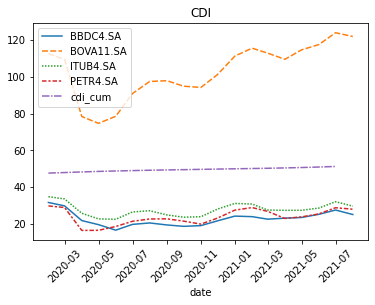

In [40]:
df_plot = df_all.loc['2020-01-01':]
g = sns.lineplot(data=df_plot);
g.set_title('CDI');
g.tick_params(axis='x', rotation=45);

In [ ]:
df_plot.iloc[1:]

In [ ]:
df_plot / df_plot.iloc[1]

In [57]:
df_temp = df_all / df_all.loc['2020-01']
df_temp

,BBDC4.SA,BOVA11.SA,ITUB4.SA,PETR4.SA,cdi_cum
date,,,,,
2016-07-31,NaN,NaN,NaN,NaN,NaN
2016-08-31,NaN,NaN,NaN,NaN,NaN
2016-09-30,NaN,NaN,NaN,NaN,NaN
2016-10-31,NaN,NaN,NaN,NaN,NaN
2016-11-30,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2021-03-31,NaN,NaN,NaN,NaN,NaN
2021-04-30,NaN,NaN,NaN,NaN,NaN
2021-05-31,NaN,NaN,NaN,NaN,NaN


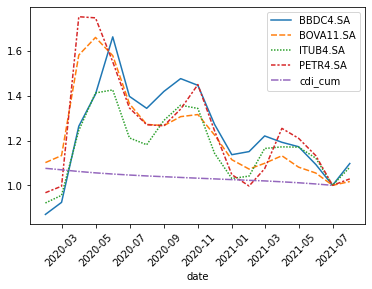

In [48]:
g = sns.lineplot(data=df_temp);
g.tick_params(axis='x', rotation=45);

In [69]:
buy = df_all.loc['2021-01']
buy

,BBDC4.SA,BOVA11.SA,ITUB4.SA,PETR4.SA,cdi_cum
date,,,,,
2021-01-31,23.893301,115.605263,30.761579,28.833684,50.09


In [70]:
sell = df_all.loc['2021-06']
sell

,BBDC4.SA,BOVA11.SA,ITUB4.SA,PETR4.SA,cdi_cum
date,,,,,
2021-06-30,27.492857,123.998571,32.026667,28.745238,51.21


In [71]:
sell.iloc[0] - buy.iloc[0]

BBDC4.SA     3.599556
BOVA11.SA    8.393308
ITUB4.SA     1.265087
PETR4.SA    -0.088446
cdi_cum      1.120000
dtype: float64

In [73]:
new_cdi_cum = sell.iloc[0]['cdi_cum'] - buy.iloc[0]['cdi_cum']
new_cdi_cum

1.1200000000000117

In [ ]:
df_delta_all = 